# Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import (make_confidence_interval_graph, 
                   get_cum_net_returns, 
                   make_plot_df, 
                   get_portfolio_returns,
                   get_cumulative_returns_matrix,
                   make_quantile_mat
                          )
from parameters import params

In [3]:
df = pd.read_csv('./data_input/histretSP.csv')

for col in ['snp500', '3mon', '10yr']:
    df[col] = df[col].str.rstrip('%').astype('float') / 100.0
df = df.set_index('year')
portfolio_allocation = np.array(
    [
    params["share_snp500"], 
    params["share_3mon"],
    params["share_10yr"], 
    ]
    )

df_all_returns = df.copy()
df_all_returns["portfolio"] = (
    get_portfolio_returns(
        df.to_numpy(), 
        portfolio_allocation,
        n_assets=3, 
        n_time_periods=df_all_returns.shape[0]
        )
        )

# EDA

In [4]:
df.mean()

snp500    0.113565
3mon      0.034263
10yr      0.050965
dtype: float64

In [5]:
df.std()

snp500    0.195817
3mon      0.030399
10yr      0.076989
dtype: float64

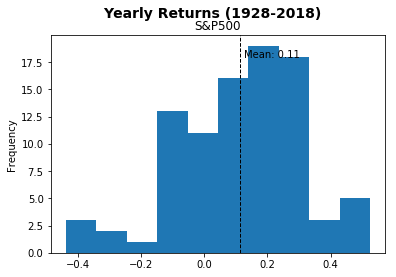

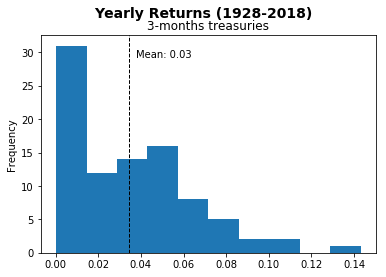

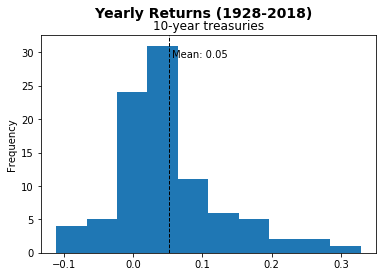

In [6]:
df.rename(columns={"snp500":"S&P500", "3mon": "3-months treasuries", "10yr": "10-year treasuries"}, inplace=True)
for col in df.columns:
    fig, ax = plt.subplots(sharex=True)
    ax = df[col].plot(kind="hist", title=col)
    plt.axvline(df[col].mean(), color='k', linestyle='dashed', linewidth=1)
    #ax.set_xlim(-0.6, 0.6)
    min_ylim, max_ylim = plt.ylim()
    plt.text(df[col].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df[col].mean()))
    fig.suptitle("Yearly Returns (1928-2018)", fontsize=14, fontweight='bold')
    #fig.title('Yearly observations from 1928 to 2018', fontsize=14, fontweight='bold');
    fig.savefig("plots/return_histogramm_{col}.png".format(col=col), transparent=False, dpi=80, bbox_inches="tight")

In [7]:
df.corr()

,S&P500,3-months treasuries,10-year treasuries
S&P500,1.000000,-0.026551,-0.021517
3-months treasuries,-0.026551,1.000000,0.297581
10-year treasuries,-0.021517,0.297581,1.000000


# Asset returns during recessions

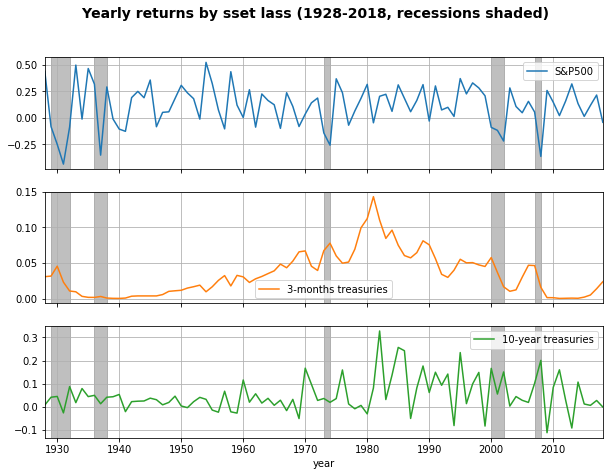

In [26]:
recessions = [df.loc[1929:1932], df.loc[1936:1938], df.loc[1973:1974], df.loc[2000:2002], df.loc[2007:2008]]
recession_corners = [[recession.index[0], recession.index[-1]] for recession in recessions]

fig, axes = plt.subplots(3,1, figsize=(10,7), sharex=True)
df.plot(subplots=True, ax=axes)
for ax in axes:
    ax.grid(True)
    for recession in recession_corners:
        ax.axvspan(recession[0], recession[1], color='grey', alpha=0.5)
fig.suptitle("Yearly returns by sset lass (1928-2018, recessions shaded)", fontsize=14, fontweight='bold')
fig.savefig("plots/returns_during_recessions.png".format(col=col), transparent=False, dpi=80, bbox_inches="tight")

# Calculate matrix with rolling 5-year returns

For each year range,
    - calculate the 5-year returns
    - write the returns for the 5 years into a new row
   
Form quantiles for each column

In [9]:
return_mat = get_cumulative_returns_matrix(df_returns=df_all_returns, 
                                     year_start=params["year_start"],
                                     year_end=params["year_end"],
                                     year_step_size=params["year_step_size"],
                                     asset_of_interest="portfolio"
                                    )
return_mat[0:10,:]

array([[100.  , 112.14, 113.06, 109.81,  97.  ,  99.43],
       [100.  , 100.82,  97.92,  86.5 ,  88.66, 100.78],
       [100.  ,  97.13,  85.8 ,  87.95,  99.97, 103.73],
       [100.  ,  88.34,  90.55, 102.92, 106.79, 121.71],
       [100.  , 102.5 , 116.51, 120.89, 137.78, 152.29],
       [100.  , 113.66, 117.94, 134.41, 148.58, 136.59],
       [100.  , 103.76, 118.25, 130.71, 120.17, 131.51],
       [100.  , 113.96, 125.97, 115.81, 126.75, 129.2 ],
       [100.  , 110.54, 101.62, 111.21, 113.37, 113.42],
       [100.  ,  91.93, 100.61, 102.56, 102.61,  98.31]])

In [10]:
return_mat.shape

(87, 6)

# Check that all entries have been filled

In [11]:
np.where(return_mat == 0)

(array([], dtype=int32), array([], dtype=int32))

# Sort matrix with returns

In [12]:
for column in range(1, return_mat.shape[1]):
    return_mat[:, column].sort()

In [13]:
return_mat[0:10,:]

array([[100.  ,  88.34,  85.8 ,  86.5 ,  88.66,  98.31],
       [100.  ,  91.93,  90.55,  87.95,  97.  ,  99.43],
       [100.  ,  95.82,  95.86,  97.72,  99.97, 100.78],
       [100.  ,  96.46,  96.4 , 101.63, 102.61, 103.73],
       [100.  ,  97.08,  97.92, 102.56, 103.6 , 111.48],
       [100.  ,  97.13, 100.61, 102.92, 106.79, 113.39],
       [100.  ,  97.31, 101.45, 103.23, 106.94, 113.42],
       [100.  ,  99.55, 101.59, 104.14, 109.15, 113.99],
       [100.  ,  99.94, 101.62, 108.5 , 109.36, 116.07],
       [100.  , 100.04, 101.98, 108.96, 111.62, 120.72]])

# Generate matrix with CI quantiles to plot

In [14]:
return_mat.shape

(87, 6)

In [15]:
quantiles = [0, 0.16, 0.5, 0.84, 1]
quantile_mat=make_quantile_mat(return_mat, quantiles)

In [16]:
df_quantile_mat = pd.DataFrame(data=quantile_mat, columns=["y0", "y1", "y2", "y3", "y4", "y5"]) 

In [17]:
df_quantile_mat

,y0,y1,y2,y3,y4,y5
0,100.0,88.3400,85.8000,86.5000,88.6600,98.3100
1,100.0,100.8008,103.2208,110.6504,115.9124,121.4356
2,100.0,106.5000,112.2500,118.0100,124.8000,130.2300
3,100.0,111.2356,121.4408,131.0852,145.6808,160.3248
4,100.0,124.2600,144.9300,160.5900,184.4100,218.1000


# Plot CI graph

In [24]:
ci_graph = make_confidence_interval_graph(df_quantile_mat)

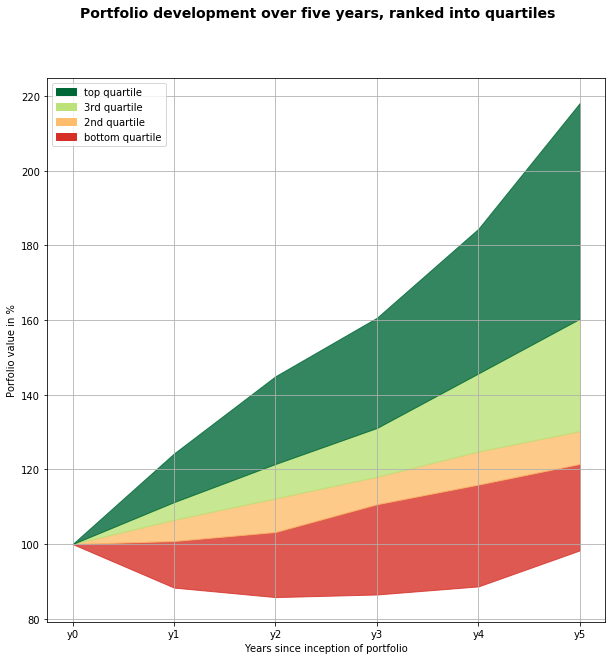

In [29]:
ci_graph.suptitle("Portfolio development over five years, ranked into quartiles", fontsize=14, fontweight='bold')
ci_graph.savefig("plots/portfolio_returns.png".format(col=col), transparent=False, dpi=80, bbox_inches="tight")
ci_graph